In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy

In [18]:
DEVICE = torch.device("cpu")
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif torch.backends.mps.is_built() and torch.backends.mps.is_available():
    DEVICE = torch.device("mps")

DEVICE = "cpu"

In [19]:
# desired size of the output image
imsize = 128

loader = transforms.Compose([
    transforms.Resize(imsize),  
    transforms.ToTensor()])  


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(DEVICE, torch.float)


style_img = image_loader("./images/picasso.jpg")
content_img = image_loader("./images/dancing.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

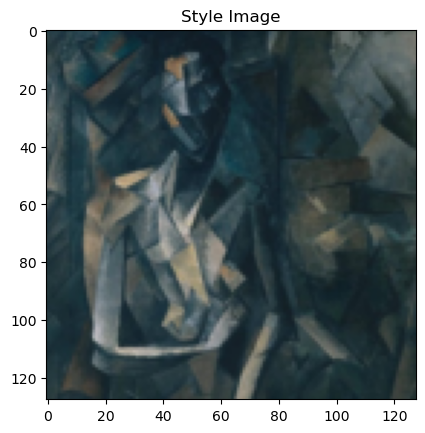

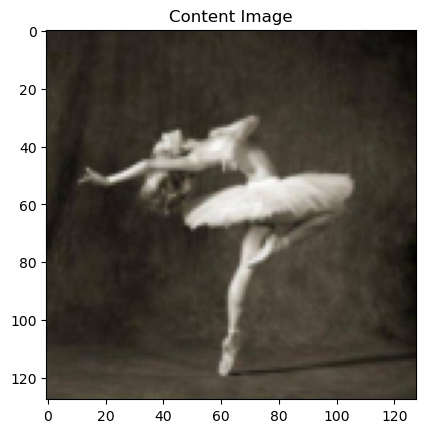

In [20]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

#allows code to be run and not blocked, waiting for closing of image windows before running rest of code
plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [21]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # the idea is we have a layer
        # we pass both the input and target through the layer
        # mean square error between the two vectors, and multiplied by some weight is the loss.
        #
        # when we back prop, we only want to send it through the model as though it has the input layer. so we need to detatch the F_CL
        # target i think is our output from F_CL?
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input
        #not a true loss function because it only calculates a static loss variable
        # does not do any automatic back prop

In [22]:
"""Finally, the gram matrix (K, N) where K is num of features and N is vectorized feature map
must be normalized by dividing each element by the total number of elements in the matrix. 
This normalization is to counteract the fact that matrices with a large N dimension 
yield larger values in the Gram matrix. These larger values will cause the first layers 
(before pooling layers) to have a larger impact during the gradient descent. 
Style features tend to be in the deeper layers of the network so this normalization step is crucial."""
#i dont get this really but will look into it further

def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [23]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [24]:
"""PyTorch’s implementation of VGG is a module divided into two child Sequential modules: 
features (containing convolution and pooling layers), and classifier (containing fully connected layers). 
We will use the features module because we need the output of the individual convolution layers to measure content and style loss. 
Some layers have different behavior during training than evaluation, so we must set the network to evaluation mode using .eval()."""

'PyTorch’s implementation of VGG is a module divided into two child Sequential modules: \nfeatures (containing convolution and pooling layers), and classifier (containing fully connected layers). \nWe will use the features module because we need the output of the individual convolution layers to measure content and style loss. \nSome layers have different behavior during training than evaluation, so we must set the network to evaluation mode using .eval().'

In [25]:
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

In [26]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(DEVICE)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(DEVICE)

# create a module to normalize input image so we can easily put it in a
# ``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1).to(DEVICE)
        self.std = torch.tensor(std).view(-1, 1, 1).to(DEVICE)

    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std

In [27]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model.to(DEVICE), style_losses, content_losses

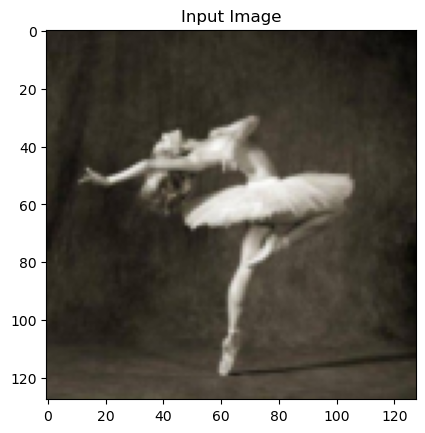

In [28]:
input_img = content_img.clone()
# if you want to use white noise by using the following code:
#
# .. code-block:: python
#
#    input_img = torch.randn(content_img.data.size())

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [29]:
# GRADIENT DESCENT
# im hella confused by this statement  
# why is it
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

# ok something about training the input image itself
# rather than training the model
# we train the input image itself???

In [30]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Building the style transfer model..
Optimizing..


/var/folders/hg/v42b6k995qddzwv77qmnn0zc0000gn/T/ipykernel_85630/3667967547.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1).to(DEVICE)
/var/folders/hg/v42b6k995qddzwv77qmnn0zc0000gn/T/ipykernel_85630/3667967547.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1).to(DEVICE)


run [50]:
Style Loss : 120.732697 Content Loss: 18.738604

run [100]:
Style Loss : 33.293190 Content Loss: 17.023094

run [150]:
Style Loss : 13.968017 Content Loss: 15.228311

run [200]:
Style Loss : 7.131367 Content Loss: 13.419202

run [250]:
Style Loss : 4.218722 Content Loss: 11.796081

run [300]:
Style Loss : 3.045388 Content Loss: 10.521832



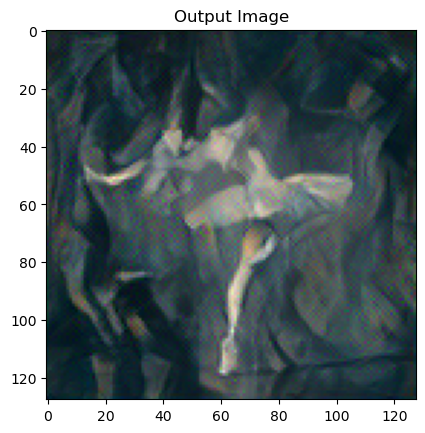

In [31]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img.to(DEVICE), style_img.to(DEVICE), input_img.to(DEVICE))

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()